## Описание проекта

Для исследования применимости алгоритмов машинного обучения в задаче расчёта высоковакуумного турбомолекулярного насоса следует решить следующие задачи:

- Решить оптимизационную задачу нахождения минимального диаметра колеса ТМН;
- Сгенерировать данные и провести по ним EDA;
- Исследовать различные модели машинного обучения на предмет предсказания минимального диаметра;
- Выбрать лучшую предсказательную модель и уточнить диапазоны оптимальных величин.
- Если возможно, получить функциональную зависимость.


Импорт библиотек и необходимых надстроек:


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import warnings

warnings.filterwarnings("ignore")

In [2]:
%config InlineBackend.figure_format = 'retina'

## Explorary Data Analys


### Начальный этап


Считываем данные из файла и создаём из них датафрейм:


In [3]:
with open("data.npy", "rb") as f:
    data = np.load(f)
print(data.shape)

(392, 5)


In [4]:
df = pd.DataFrame(data, columns=["c_1", "alpha_rad", "lambda", "ab_1", "F_min"])
df.head()

,c_1,alpha_rad,lambda,ab_1,F_min
0,0.2,0.349066,0.6,0.99,52.061780
1,0.2,0.436332,0.6,0.98,47.650602
2,0.2,0.523599,0.6,0.97,44.733609
3,0.2,0.610865,0.6,0.95,42.723213
4,0.2,0.698132,0.6,0.93,41.316978


Для дальнейшей визуализации подкорректируем данные: $c_1$ округлим до 2 значащих цифр после запятой и добавим столбец с углом наклона лопаток в градусах.


In [5]:
df["c_1"] = np.round(df["c_1"], 2)
df["ab_1"] = np.round(df["ab_1"], 2)

df["alpha_deg"] = np.round(np.rad2deg(df["alpha_rad"]))

df.head()

,c_1,alpha_rad,lambda,ab_1,F_min,alpha_deg
0,0.2,0.349066,0.6,0.99,52.061780,20.0
1,0.2,0.436332,0.6,0.98,47.650602,25.0
2,0.2,0.523599,0.6,0.97,44.733609,30.0
3,0.2,0.610865,0.6,0.95,42.723213,35.0
4,0.2,0.698132,0.6,0.93,41.316978,40.0


Отсортируем данные, чтобы придать им более наглядную форму:


In [6]:
df = df.sort_values(by=["alpha_rad", "c_1"]).reset_index(drop=True)
df.head()

,c_1,alpha_rad,lambda,ab_1,F_min,alpha_deg
0,0.20,0.349066,0.6,0.99,52.061780,20.0
1,0.21,0.349066,0.6,0.99,49.568306,20.0
2,0.22,0.349066,0.6,0.99,47.300823,20.0
3,0.23,0.349066,0.6,0.99,45.229849,20.0
4,0.24,0.349066,0.6,0.99,43.330818,20.0


Общая информация о полученных данных:


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   c_1        392 non-null    float64
 1   alpha_rad  392 non-null    float64
 2   lambda     392 non-null    float64
 3   ab_1       392 non-null    float64
 4   F_min      392 non-null    float64
 5   alpha_deg  392 non-null    float64
dtypes: float64(6)
memory usage: 18.5 KB


In [8]:
df.describe()

,c_1,alpha_rad,lambda,ab_1,F_min,alpha_deg
count,392.000000,392.000000,3.920000e+02,392.000000,392.000000,392.00000
mean,0.475000,0.610865,6.000000e-01,0.936658,21.004294,35.00000
std,0.161839,0.174756,1.111642e-16,0.041479,9.014719,10.01278
min,0.200000,0.349066,6.000000e-01,0.850000,9.966930,20.00000
25%,0.337500,0.436332,6.000000e-01,0.900000,13.898876,25.00000
50%,0.475000,0.610865,6.000000e-01,0.950000,18.250428,35.00000
75%,0.612500,0.785398,6.000000e-01,0.970000,26.181891,45.00000
max,0.750000,0.872665,6.000000e-01,0.990000,52.061780,50.00000


Проверим количество уникальных значений в каждом столбце:


In [9]:
df.nunique().sort_values()

lambda         1
alpha_rad      7
alpha_deg      7
ab_1          15
c_1           56
F_min        392
dtype: int64

### Изучение данных


Находим, что в столбце $\lambda$ только одно уникальное значение, которое примем оптимальным независимо от всех остальных параметров для первого пакета колес ТМН.


In [10]:
print(f'Оптимальное значение lambda = {df["lambda"].unique()}')

Оптимальное значение lambda = [0.6]


Из всего набора значений $ab_1$ алгоритм оптимизации отобрал только 15 элементов. Рассмотрим их детальнее:


In [11]:
ab_1_nuniques = df.ab_1.nunique()
ab_1_bounds = np.sort(df.ab_1.unique())
print(
f"""Количество уникальных значений ab_1 = {ab_1_nuniques}
Диапазон ab_1: {ab_1_bounds}"""
)

Количество уникальных значений ab_1 = 15
Диапазон ab_1: [0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]


Это позволяет уточнить диапазон оптимальных отношений до $ab_1 \in [0.85, 1)$.


Изучим также линейные(pearson) и нелинейные(spearman) корреляции между признаками:


In [12]:
for method in ["pearson", "spearman"]:
    print(f"{method.title()} correlation:")
    display(
        df.drop(["lambda", "alpha_rad"], axis=1)
        .corr(method=method)
        .style.background_gradient(cmap="viridis")
    )

Pearson correlation:


,c_1,ab_1,F_min,alpha_deg
c_1,1.000000,-0.136222,-0.916123,0.000000
ab_1,-0.136222,1.000000,0.305542,-0.972655
F_min,-0.916123,0.305542,1.000000,-0.212199
alpha_deg,0.000000,-0.972655,-0.212199,1.000000


Spearman correlation:


,c_1,ab_1,F_min,alpha_deg
c_1,1.000000,-0.143718,-0.969031,0.000000
ab_1,-0.143718,1.000000,0.359003,-0.985375
F_min,-0.969031,0.359003,1.000000,-0.225615
alpha_deg,0.000000,-0.985375,-0.225615,1.000000


Наблюдаем большие корреляции между парами признаков $c_1 - F_{min}$ и $\alpha - ab_1$. Построим матрицу корреляций для ряда прикнаков, чтобы иметь о них более точное представление:


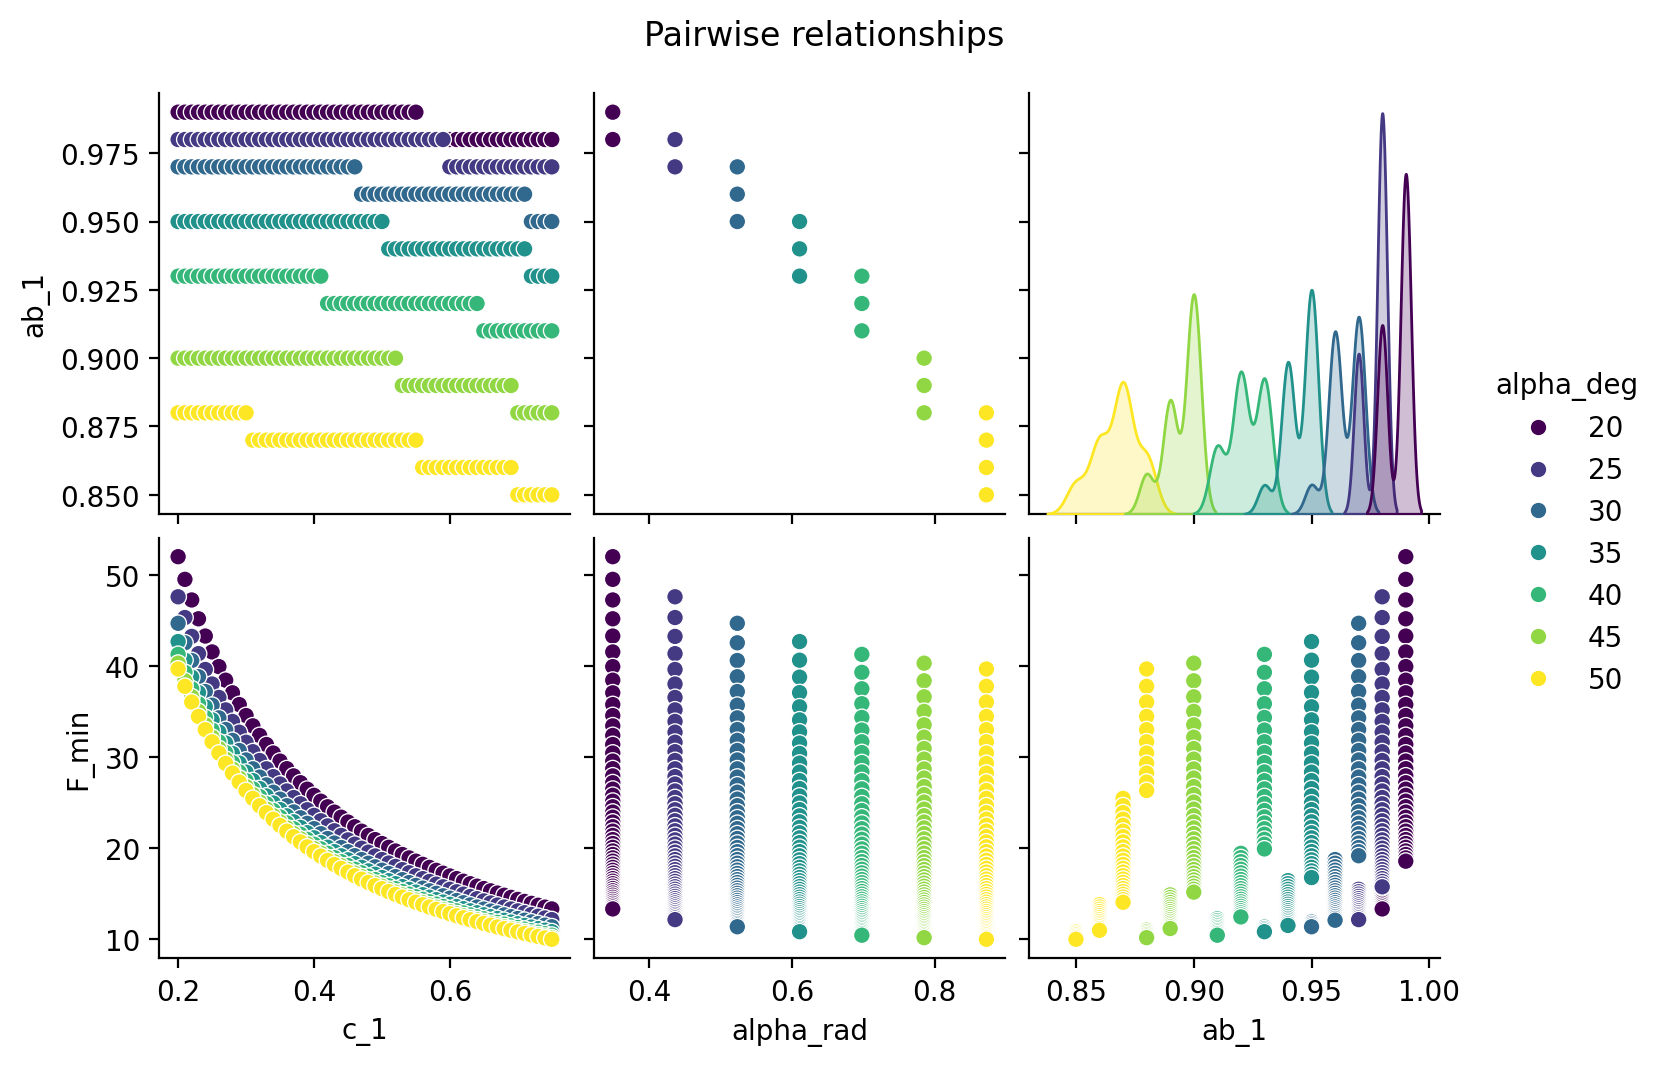

In [13]:
g = sns.pairplot(
    df,
    x_vars=["c_1", "alpha_rad", "ab_1"],
    y_vars=["ab_1", "F_min"],
    hue="alpha_deg",
    palette="viridis",
)
g.fig.suptitle("Pairwise relationships", y=1.05)
plt.show()

Из данного графика можно сделать ряд наблюдений:

- Между $c_1$ и $F_{min}$ есть нелинейная обратная связь;
- С увеличением угла наклона лопаток уменьшается не только $F_{min}$, но и оптимальное значение $ab_1$;
- Меньшим значениям $ab_1$ соответствуют меньшие значения $F_{min}$;
- Также можно заметить что график не является непрерывным и с изменением набора ($c_1$, $\alpha$) для сохранения минимума F $ab_{1опт}$ начинает принимать меньшие значения.


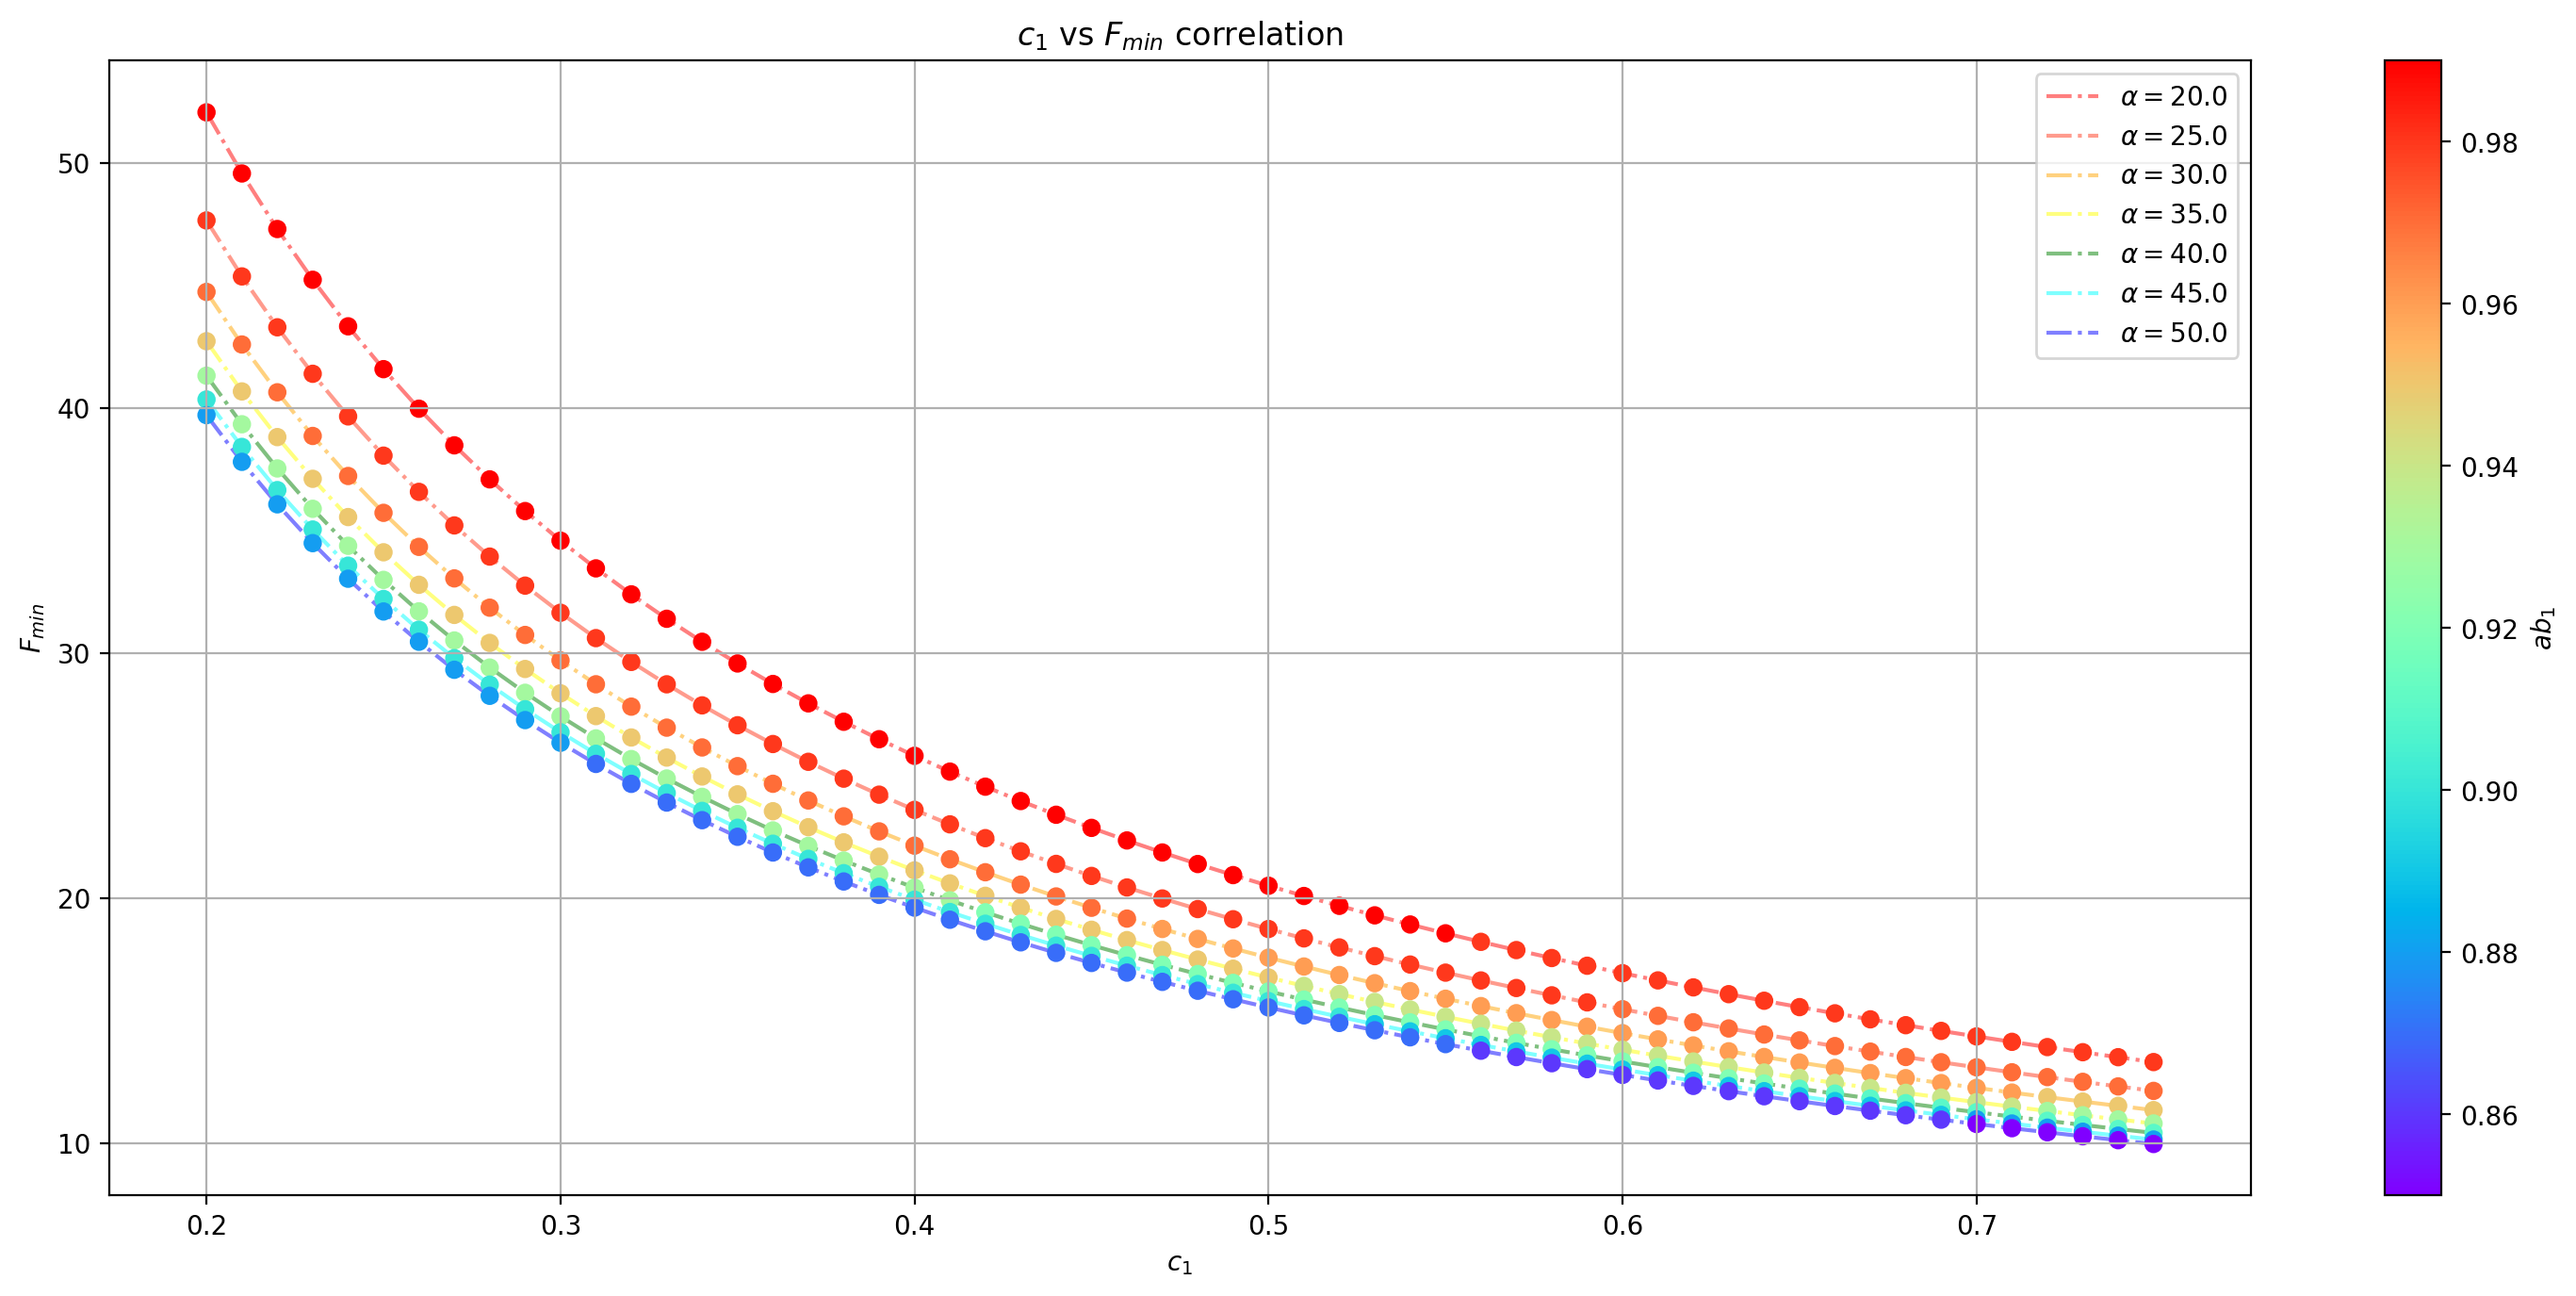

In [14]:
colors = ["red", "#ff381c", "orange", "yellow", "green", "cyan", "blue"]
fig, ax = plt.subplots(figsize=(15, 7))
plot1 = ax.scatter(df["c_1"], df["F_min"], c=df["ab_1"], cmap="rainbow")
ax.set(xlabel=r"$c_1$", ylabel=r"$F_{min}$", title=r"$c_1$ vs $F_{min}$ correlation")

for color, alpha in zip(colors, df["alpha_deg"].unique()):
    ax.plot(
        df[df["alpha_deg"] == alpha]["c_1"],
        df[df["alpha_deg"] == alpha]["F_min"],
        "-.",
        color=color,
        zorder=0,
        alpha=0.5,
        label=rf"$\{alpha = }$",
    )
fig.colorbar(plot1, ax=ax, label=r"$ab_1$")
fig.tight_layout()
ax.grid(True)
ax.legend()

plt.show()

Исследуем графики $F_{min}$ для различных наборов параметров. Поскольку $\lambda$ постоянна и её можно исключить из построения, основными параметрами выступают $ab_1$, $\alpha$ и $с_1$. Рациональней всего строить зависимость F($c_1$) при разных значениях $\alpha$, а параметр $ab_1$ определять цветом маркеров.


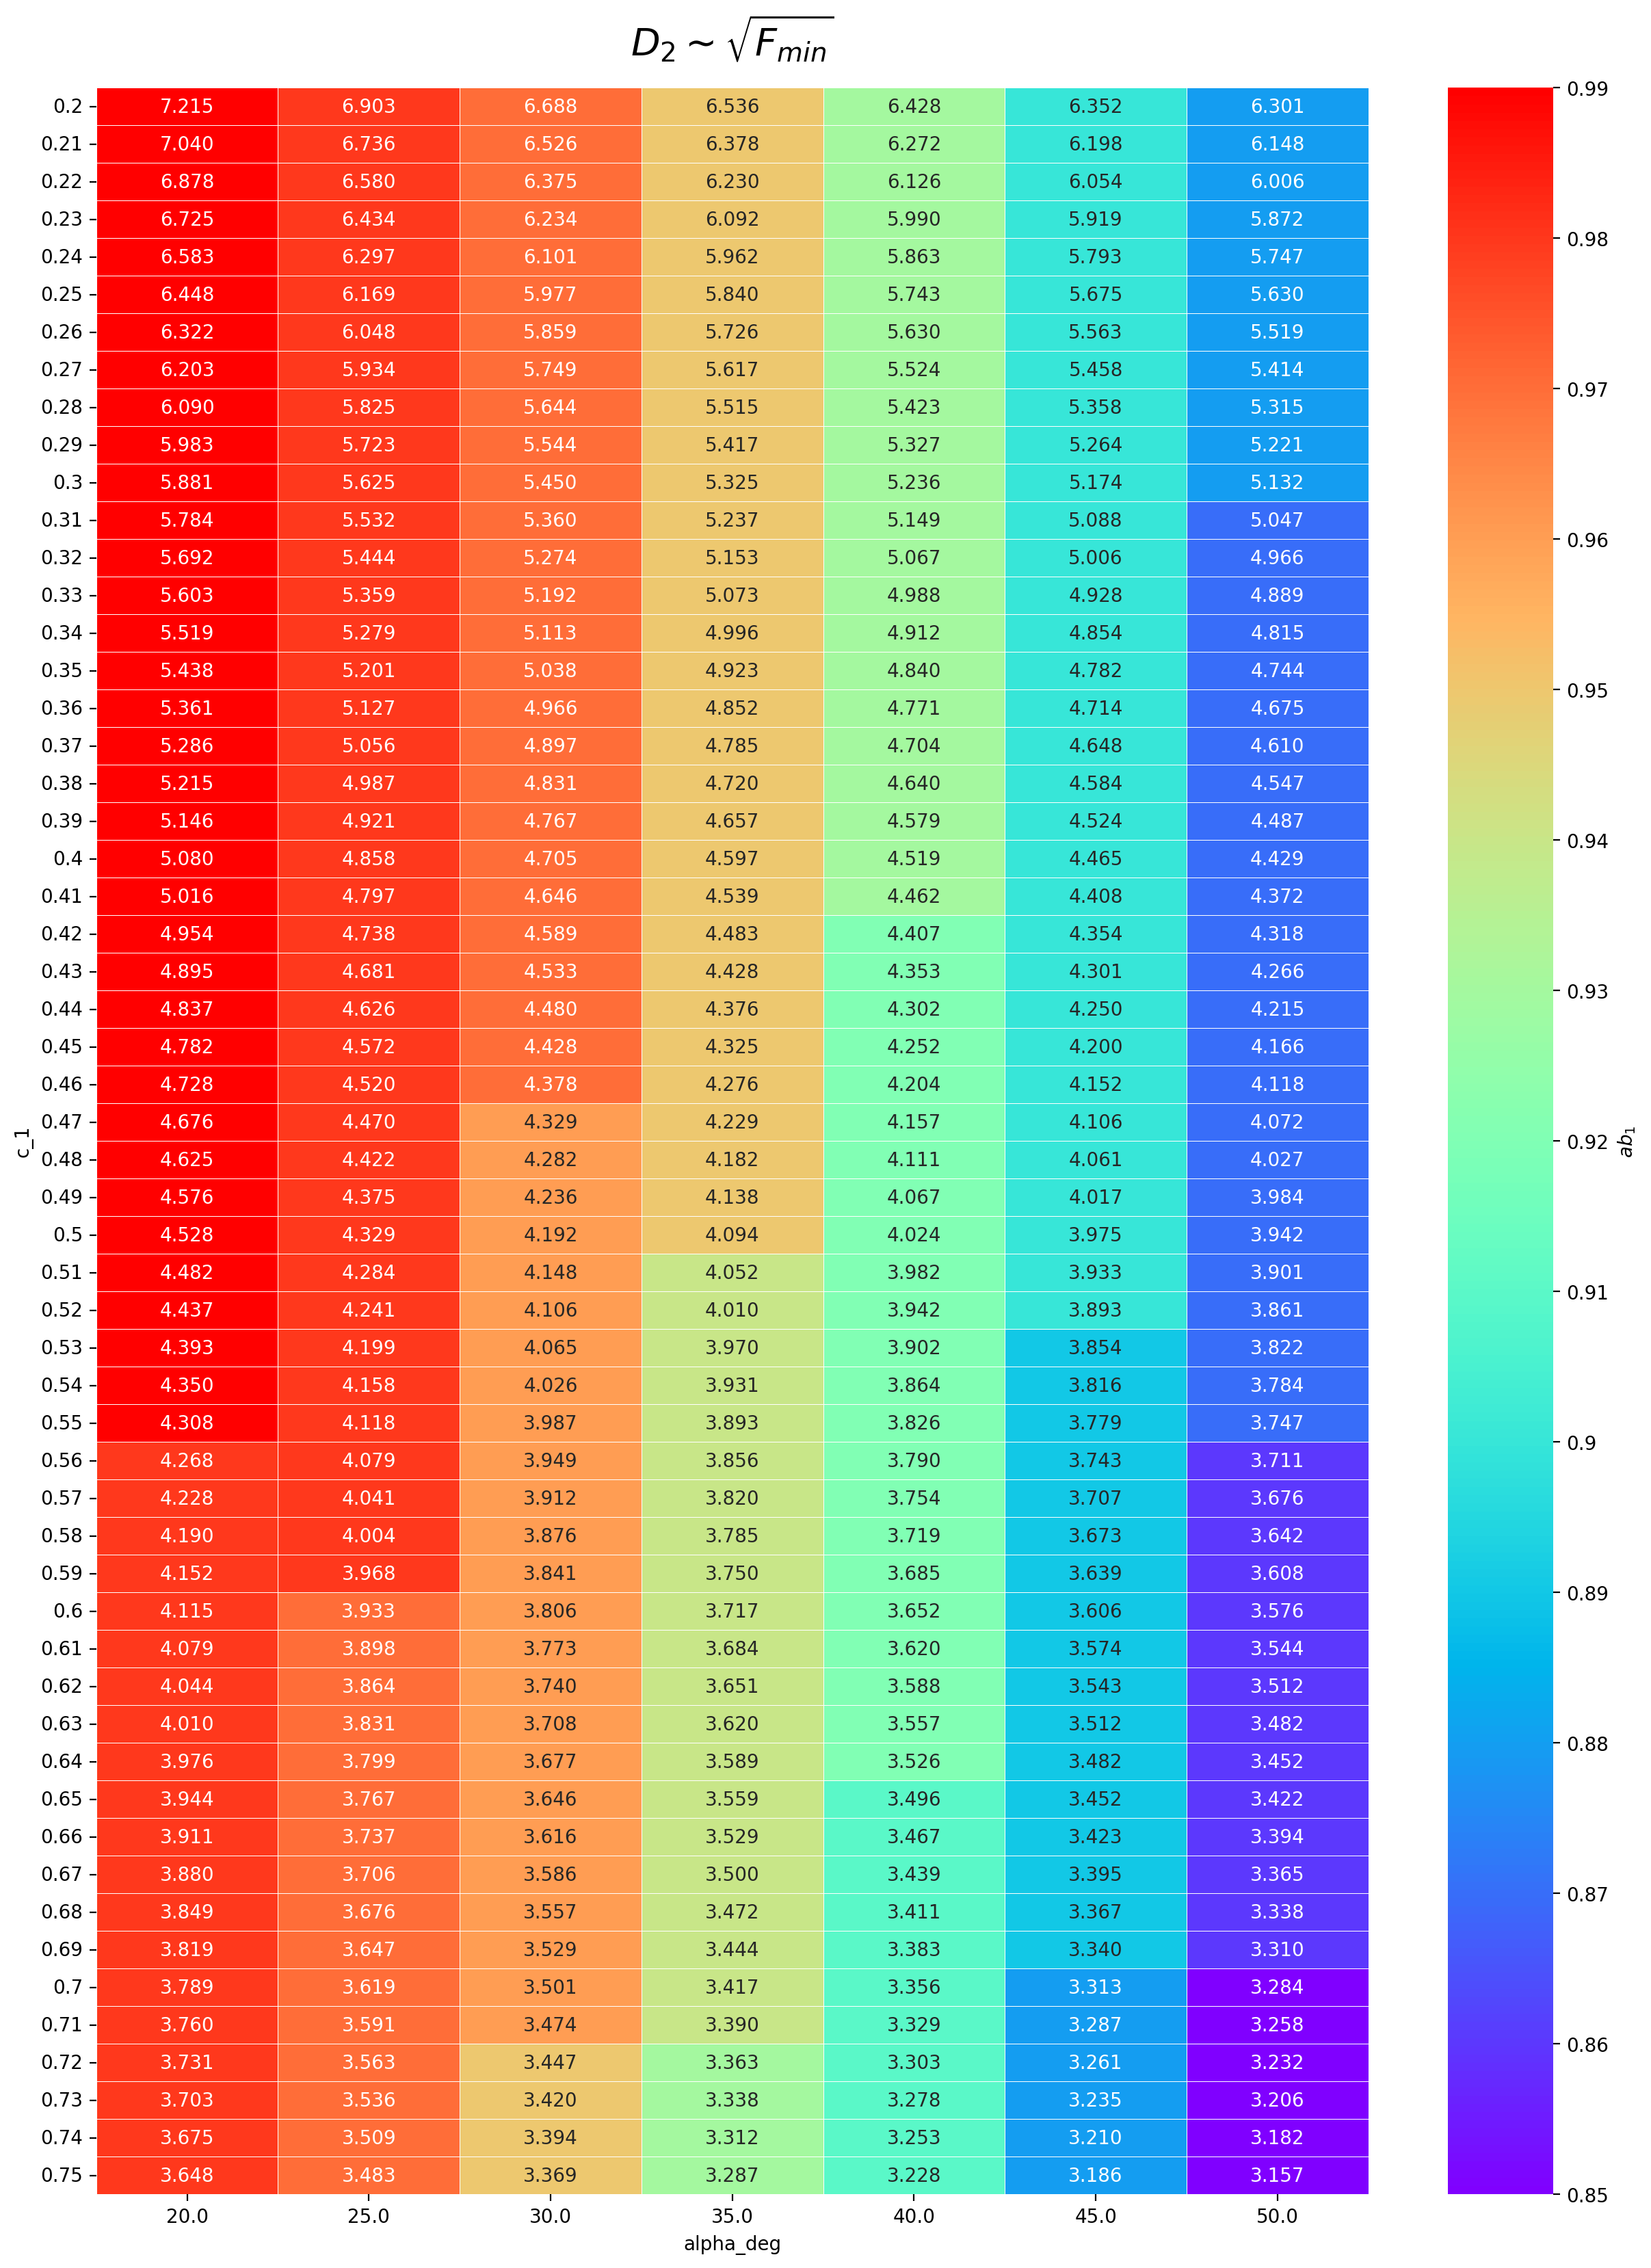

In [17]:
fig, ax = plt.subplots(figsize=(15, 20))
df_pivot = df[["c_1", "alpha_deg", "ab_1"]].pivot(
    index="c_1", columns="alpha_deg", values="ab_1"
)
f_1sqrt = np.sqrt(data[:, -1]).reshape(df.c_1.nunique(), df.alpha_deg.nunique())
ax.set_title(r"$D_2 \sim \sqrt{F_{min}}$", y=1.01, fontsize=20)
ax = sns.heatmap(df_pivot, annot=f_1sqrt, fmt=".3f", lw=0.2, ax=ax, cmap="rainbow")
cbar = ax.collections[0].colorbar
cbar.set_ticks(df.ab_1.unique())
cbar.set_ticklabels([*map(str, df.ab_1.unique())])
cbar.set_label(r"$ab_1$")
plt.show()

Выводы:

- Оптимальное значение $\lambda_{опт}=0.6$ независимо от геометрии колеса или откачиваемого газа.
- Оптимальный диапазон параметра $ab_{1опт} \in [0.85, 1)$.
- Обнаружены высокие линейные корреляции между $c_1$ и $F_{min}$, а также между $ab_1$ и $\alpha$, однако прослеживается нелинейная зависимость между параметрами.
- Составлена наглядная схема, по которой при заданном значении $c_1$ можно выбирать оптимальные параметры колеса, обеспечивающие минимальный диаметр.


## Построение моделей


Выводы:


## Общие выводы
